# BSOC as a Convoultional Layer

This work is based on papers by Dr. Gabriel Ferrer from Hendrix College. I will explore the practicality of using Bounded Self-Organizing Clusters (BSOC) as a way to create the first convoultional in a convoultional network. I will be using Pytorch as a baseline in this notebook.

## Data:
The data comes from pictures taken on a Galaxy S8 at 1280x720px.
### 7/9/2018
Room: 10 Pictures <br/>
Kitchen: 10 Pictures

## 1: Running a basic test with CIFAR10:

In [3]:
## Loading the Data
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
  car  ship  frog  frog


torch.Size([3, 32, 32])

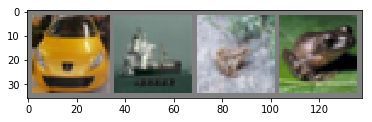

In [4]:
imshow(torchvision.utils.make_grid(images))
images[0].shape

In [5]:
np.zeros((2,3,4)) ## creates 2, 3x4 arrays
import heapq as hq

## Let's write a wrapper around heapq to help keep us sane.
## this heap needs to let us remove an arbitrary amount of edges

class Heap():
    def __init__(self):
        self.list = []
    def add(self, item, priority=0):
        hq.heappush(self.list, (priority, item))
    def add_many(self, entries_list, entries_priorities):
        self.list += [li for li in zip(entries_priorities, entries)]
        hq.heapify(self.list)
    def pop(self):
        return hq.heappop(self.list)
    def filter_f(self, filter_func):
        self.list = list(filter(filter_func, self.list))
        hq.heapify(self.list)
    def remove_many(self, entries):
        set_check = set(entries)
        self.list = [(p,e) for p,e in self.list if e not in set_check]
        hq.heapify(self.list)
        ## we do this because it is faster to create a new list rather than modify a ton of items in a list
        ## Todo, check if this is faster than a for loop to remove each item from a list.
    def __remove_1(self, entry):
        i_to_remove = -1;
        for i in range(len(self.list)):
            p,e = self.list[i]
            if e == entry:
                i_to_remove = i
        if i_to_remove == -1:
            raise ValueError("Could not find entry in heap")
        del self.list[i_to_remove]
    
    def remove_any_instance_of(self, i):
        self.list = [(p,e) for (p,e) in self.list if (e.a != i and e.b != i)]
        hq.heapify(self.list)
    def remove(self, entry):
        self.__remove_1(entry)
        hq.heapify(self.list)
    def remove_many_inplace(self, entries):
        for e in entries:
            self.__remove_1(e)
        
    
        
## Let's also just name our edges
class Edge():
    def __init__(self, a, b, weight):
        self.a = a
        self.b = b
        self.weight = weight
    def __eq__(self, other):
#         print(type(self.a))
#         print(type(self.b))
        return other.contains(self.a) and other.contains(self.b) and other.weight == self.weight

    def __lt__(self, other):
        return self.weight < other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __gt__(self, other):
        return self.weight > other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight
    
    def __repr__(self):
        return str(self.a.ID) + " " + str(self.b.ID) + " " + str(self.weight)
    ## checks if a or b is c
    def contains(self, c):
        t1 = self.a == c
        t2 = self.b == c
        return t1 or t2
        
        

# Defining BSOC

In [6]:
class BSOC_Image_Node():
    def __init__(self, node_height, node_width, node_channels, ID = -1,  merge_count = 1, array=None):
        self.height = node_height
        self.width = node_width
        self.channels = node_channels
        self.ID = ID
        
        if array is None:
            self.array = np.zeros(shape=(node_height, node_width, node_channels))
        else :
            self.array = array
        self.merge_count = merge_count
    
    ## Returns a new node of this node and the other node merged together
    ## merge_f(node1, node2) returns new node. 
    def merge(self, other_node, new_ID, merge_func = None):
        if merge_func == None:
            ## default merge
            newCount = self.merge_count + other_node.merge_count
            a1 = self.array
            a2 = other_node.array
            r1 = self.merge_count / newCount
            r2 = other_node.merge_count / newCount
            a3 = (a1 * r1) + (a2 * r2)
            return BSOC_Image_Node(self.height, self.width, self.channels, ID=new_ID, merge_count = newCount, array=a3)
        return merge_func(self, other_node)
    
    def __eq__(self, other):
        return other.ID == self.ID
#         return np.array_equal(self.array, other.array) and self.merge_count == other.merge_count
    def __repr__(self):
        return self.array.__repr__()
        
    def calculate_distance(self, other):
        return (self.merge_count + other.merge_count) * np.sum(np.absolute(self.array - other.array))
        
        
        
class BSOC():
    def __init__(self, nodes_count, node_channels=1):
        self.total_nodes = nodes_count
        self.node_channels = node_channels
        self.node_list = []
        self.pq = Heap()
        self.generator = self.__default_generator()
        
    def __default_generator(self):
        i = 0
        while True:
            yield i
            i += 1
    def next_ID(self):
        return next(self.generator)
    ## if we're below the node threshold, then place the pixel array into the numpy list, 
    def add_node(self, pixel_arr):
        node = BSOC_Image_Node(pixel_arr.shape[0], pixel_arr.shape[1], pixel_arr.shape[2], ID=self.next_ID(), array=pixel_arr)
        ## Add the node to the priority queue. 
        self.add_node_and_edges(node)
        if len(self.node_list) > self.total_nodes:
            weight, e = self.pq.pop()
            self.node_list = [x for x in self.node_list if x not in (e.a, e.b) ] ## deletes a and b from the list
            self.pq.remove_any_instance_of(e.a)
            self.pq.remove_any_instance_of(e.b)
            self.__merge(e.a, e.b)

            
                    
    def add_node_and_edges(self, node):
        for n in self.node_list:
            e = Edge(node, n, weight=n.calculate_distance(node))
            self.pq.add(e, e.weight)
        self.node_list.append(node)

    ## merges nodes a and b and adds their respective edges to the priority queue
    ## merge_func = function to merge together the nodes at the indeces
    def __merge(self, a, b, merge_func=None):
        new_node = a.merge(b, self.next_ID(), merge_func)
        self.add_node_and_edges(new_node)

        
    ## Only works on raw images, if converted to tensors or loaded from pytorch default libraries, it won't show
    def print_bsoc(self, ncols=-1, nrows=1):
        if ncols * nrows < len(self.node_list):
            ncols = len(self.node_list)
        fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 10))
        print(len(self.node_list))
            
        for i in range(len(self.node_list)):
            a = axeslist.ravel()[i]
            a.imshow(self.node_list[i].array.astype(np.int64))
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
            a.set_title('Merged {}x {}'.format(self.node_list[i].merge_count, self.node_list[i].ID))
            

# BSOC Test

We need to verify that we correctly implemented BSOC, so let's see the output of combining a few images together

## Loading data

In [7]:
# Get out data files
import os

## Creating a base class for our dataset
from torch.utils.data import Dataset
from PIL import Image

class simpleImageDataset(Dataset):
    """ Loads images, it assumes that the folder in which the file is stored is the label """
    
    def __init__(self, directory, transform=None):
        self.label_to_ind_dict = {}
        self.ind_to_label = {}
        self.labels = []
        self.file_paths = []
        self.transform = transform
        self.label_count = 0
        for dirpath, dirname, filenames in os.walk(directory):
            for file in filenames:
                label = dirpath.split(os.sep)[-1]
                if label not in self.label_to_ind_dict:
                    self.label_to_ind_dict[label] = self.label_count
                    self.ind_to_label[self.label_count] = label
                    self.label_count += 1
                self.labels.append(dirpath.split(os.sep)[-1])
                self.file_paths.append(os.path.join(dirpath, file))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx])
        label = self.labels[idx]
        sample = {'image':image}
        
        if self.transform:
            sample = {'image': self.transform(image)}
        return sample
    def label_for(self, idx):
        return self.labels[idx]
    def label_tensor(self, idx):
        return torch.Tensor([self.label_to_ind_dict[self.label_for(idx)], self.label_count])

## Viewing our Data
room_dataset = simpleImageDataset("./Data", transform=transforms.Compose([transforms.Resize((72,128)),
                                                                            transforms.ToTensor()]))
# fig = plt.figure(figsize=(20,10))
# for i in range(len(room_dataset)):
#     sample = room_dataset[i]
#     ax = plt.subplot(1, 4, i+1)
#     plt.tight_layout()
#     ax.set_title("sample #{}".format(i))
#     ax.axis('off')
    
#     plt.imshow(sample['image'])
#     if i==3:
#         plt.show()
#         break

In [8]:
import time

## Generates kernels_count kernels of kernel_size from dataset 
def generate_kernels(kernels_count, kernel_size, dataset):
    start_time = time.time() * 1000
    bsoc = BSOC(nodes_count=kernels_count)
    offset = (kernel_size // 2) * 2
    for i,data in enumerate(dataset, 0):
#     for i in range(1):
        image = data[0].numpy()
        ## Iterate through the image
        for r in range(len(image[1]) - offset):
            r_stop = r + kernel_size
            for c in range(len(image[2]) - offset):
                bsoc.add_node(image[:,r:r_stop, c:c+kernel_size])
    print("Total time in milli: " + str(time.time()*1000 - start_time))
    return bsoc

10


[37, 40, 37, 36, 35, 33, 39, 38, 42, 63]

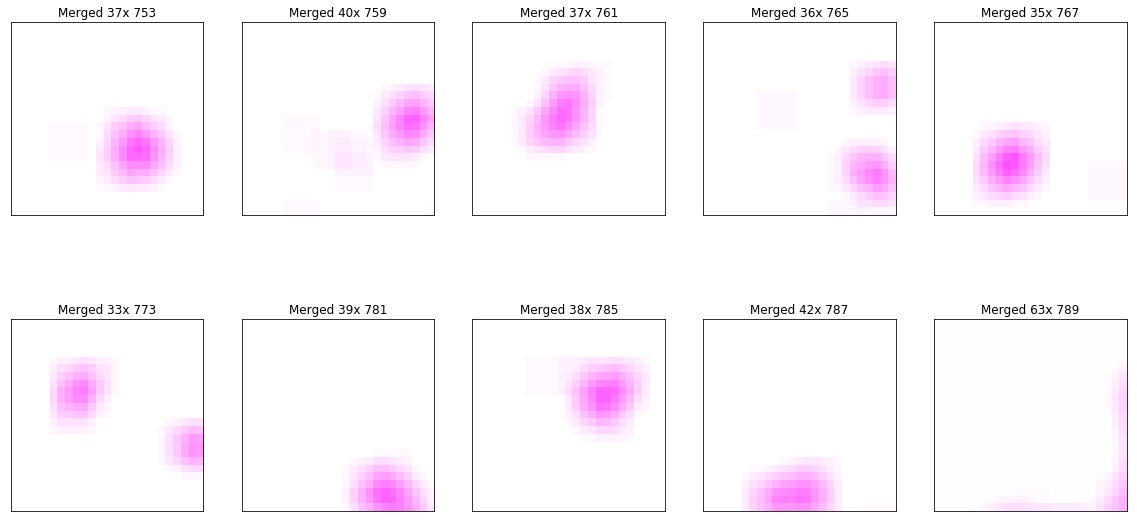

In [19]:

test_dataset = simpleImageDataset("./test_data/")
bsoc = BSOC(nodes_count=10)

for i in range(len(test_dataset)):
    bsoc.add_node(np.array(test_dataset[i]['image']))
bsoc.print_bsoc(nrows=2, ncols=5)
[x.merge_count for x in bsoc.node_list]


In [9]:
room_dataset2 = torchvision.datasets.ImageFolder(root="./Data",transform=transforms.Compose([transforms.Resize((72,128)),
                                                                                    transforms.ToTensor()]))

roomLoader = torch.utils.data.DataLoader(room_dataset2,batch_size=20,
                                          shuffle=False, num_workers=2)

In [10]:
bsoc = generate_kernels(10, 5, room_dataset2)

Total time in milli: 33588.87744140625


In [11]:
kernels = [x.array for x in bsoc.node_list]
kernels = torch.from_numpy(np.array(kernels))
kernels.shape

torch.Size([10, 3, 5, 5])

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import queue



class BSOCNet(nn.Module):
    def __init__(self):
        super(BSOCNet, self).__init__()
        self.fc = nn.Linear(10 * 70 * 126, 2)
        
    def forward(self, x):
        x = F.conv2d(x, kernels, stride=1, padding=1)
        x = x.view(-1, 10*70*126)
        x = self.fc(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.fc1 = nn.Linear(10 * 28 * 28, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10 * 28 * 28)
        x = self.fc1(x)
        return x
        
net = BSOCNet()

It looks like from [here](https://discuss.pytorch.org/t/defining-a-conv2d-layer-with-fixed-kernel/8684) that we can use F.conv2d to manually define layers [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d) and [this](https://discuss.pytorch.org/t/pytorch-replace-torch-nn-conv2d-with-torch-nn-functional-conv2d/16596) link might help if we get errors

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(40):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(roomLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#         print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
print('Finished Training')

Finished Training


In [15]:
for i,data in enumerate(roomLoader, 0):
    inputs, labels = data
    print(net(inputs))

tensor([[  2270.8113,  -2257.2842],
        [  2288.5723,  -2271.4128],
        [  2124.9937,  -2099.7427],
        [ 12125.0576, -12108.4023],
        [  1946.4172,  -1926.4924],
        [  4661.0884,  -4633.8218],
        [ 10986.6514, -10961.8867],
        [  4205.2773,  -4180.6685],
        [  8895.5410,  -8867.7793],
        [  2020.2233,  -1995.1459],
        [ -5775.3550,   5800.7222],
        [ -5947.3828,   5966.2764],
        [ -8037.9814,   8063.1055],
        [ -7091.5361,   7121.7837],
        [ -7275.2842,   7298.7637],
        [-10528.8818,  10556.1943],
        [-12435.0107,  12455.8955],
        [-15039.8457,  15059.7246],
        [-18823.2637,  18845.5371],
        [-21256.7344,  21275.5527]])


Evidently, using only a Convoluted layer and a MLP/Dense layer is not a good classifier. The commented out code above is the tuorial which gives much lower loss (around 1.12)

(10, 3, 5, 5)
(3,)
[[-0.09637843  0.08512098  0.11013851 -0.01549788  0.02775969]
 [ 0.06870964  0.05168772 -0.03357208 -0.06287108  0.02407114]
 [-0.0111529  -0.08104364  0.03487998 -0.10813116  0.00409912]
 [ 0.01432148  0.07148701  0.06743662 -0.0345263   0.05942763]
 [ 0.08592044  0.0579102  -0.0812898   0.05857071  0.0347359 ]]
0
[[ 0.10365884 -0.00947934  0.05508061  0.09593777  0.11002512]
 [ 0.02702767  0.11001402  0.07536751  0.06760682 -0.02529428]
 [-0.01035385 -0.02507612  0.04104014 -0.05594692 -0.03454244]
 [ 0.10841495 -0.07611939  0.07138833  0.02999318  0.04930627]
 [ 0.0108217   0.02096641  0.10466358  0.0571364  -0.09553624]]
10
[[ 0.10512796 -0.03005054 -0.00940652  0.08912785 -0.03248838]
 [ 0.0964251   0.11412682 -0.02998253  0.02109608 -0.06853302]
 [-0.06128663  0.01218118  0.10603376  0.01264136  0.06043579]
 [-0.07368945 -0.0846523  -0.02348094  0.02945076 -0.02664285]
 [-0.00015405 -0.02702193 -0.08856401  0.10429175  0.10138449]]
20


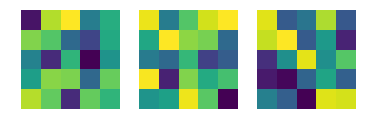

In [34]:
def view_kernels(tensor):
    width, height, kern_width, kern_height = tensor.shape
    _, axarr = plt.subplots(1 , height)
    print(axarr.shape)
    h = 0
    w = 0
    while ((h * height + w * width) < (height * width)):
        axarr[w].axis('off')
        axarr[w].imshow(tensor[w][h])
        print(tensor[w][h])
        print((h * height + w * width))
        w += 1
        if w >= width:
            h += 1
            w = 0
    
    
count = 0
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        if count == 0:
            print((m.weight.data.numpy().shape))
            view_kernels(m.weight.data.numpy())
        count += 1

# TODO
* How do people define convolutional layers initially besides random. 
* ConvNet with fixed kernels and without (no back propagation) 
* ConvNet without fixed kernels (Normal)
* BSOCNet with Fixed kernels (Hypothesis)
* BSOCNet with without fixed kternels. 
* how are the convolutional network weights back propagated?
* Generate white images with red squares in them to see if bsoc works correctly

In [577]:
width = 100
height = 100
steps = 20
radius = 20
w_step = (width - radius) // steps
h_step = (height - radius) // steps
count = 0
for r in range(steps):
    h_start = radius + r * h_step
    for c in range(steps):
        count += 1
        w_start = radius + c * w_step
        img = np.zeros([width, height,3],dtype=np.uint8)
        img.fill(255)
        img[h_start:h_start+radius, w_start:w_start+radius, 1] = 0
        im = Image.fromarray(img)
        im.save("./test_data/{}.png".format(count))



In [470]:
import numpy as np